Удалила "2 Зрелый почерк-(обычный почерк)-2.jpg" (там печатный текст)

# Config

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
cd drive/MyDrive/Colab\ Notebooks/mest

/content/drive/MyDrive/Colab Notebooks/mest


In [3]:
DATA = "bin"
DATA_POS = f"{DATA}/1"
DATA_NEG = f"{DATA}/0"

import torch
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
THRESHOLD = 0.999 # доля белого
SEED = 42
BATCH_SIZE = 8
LR = 1e-4
EPOCHES = 29
POS_AUG = 22
NEG_AUG = 2
PATH = "m.pth"
LOG_PATH = "log.txt"

glob_dict = {
    "DEVICE": DEVICE,
    "THRESHOLD": THRESHOLD,
    "SEED": SEED,
    "BATCH_SIZE": BATCH_SIZE,
    }

from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.metrics import accuracy_score
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader
from time import time

from src.functions import *
from src.show_fun import *
from src.dataset import *
from src.dataset_fun import *
from src.train import *
from src.train_siam import *

print(f"{DEVICE = }")

DEVICE = device(type='cuda')


In [4]:
"seed_everything(42)"

'seed_everything(42)'

# Dataset

In [5]:
transform = transforms.Compose([
    transforms.RandomCrop(300),
    # transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    # transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
])

pos_dataset = My_Dataset(
    "pos", DATA_POS, augmentation=POS_AUG, transform=transform, globals=glob_dict)
print(f"Positive: {len(pos_dataset)}    ({pos_dataset.real_len})")

neg_dataset = My_Dataset(
    "neg", DATA_NEG, augmentation=NEG_AUG, transform=transform, globals=glob_dict)
print(f"Negative: {len(neg_dataset)}    ({neg_dataset.real_len})")

dataset = torch.utils.data.ConcatDataset([pos_dataset, neg_dataset]) # подряд идут 1, потом 0
print(f"ConcatDataset: {len(dataset)}")

Positive: 484    (22)
Negative: 448    (224)
ConcatDataset: 932


In [6]:
seed_everything(42)
train_dataset, test_dataset = split_dataset(dataset)

Train: 745
 Test: 187
 Total: 932


# Dataloader

In [7]:
seed_everything(42)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader  = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

print(f"Train batches: {len(train_loader)}\n Test batches: {len(test_loader)}")

Train batches: 94
 Test batches: 24


In [8]:
pos_neg(train_loader)

{'1': 381, '0': 364, 'total': 745}

In [9]:
pos_neg(test_loader)

{'1': 103, '0': 84, 'total': 187}

torch.Size([8, 3, 224, 224]) tensor([1, 1, 0, 0, 1, 1, 1, 0])


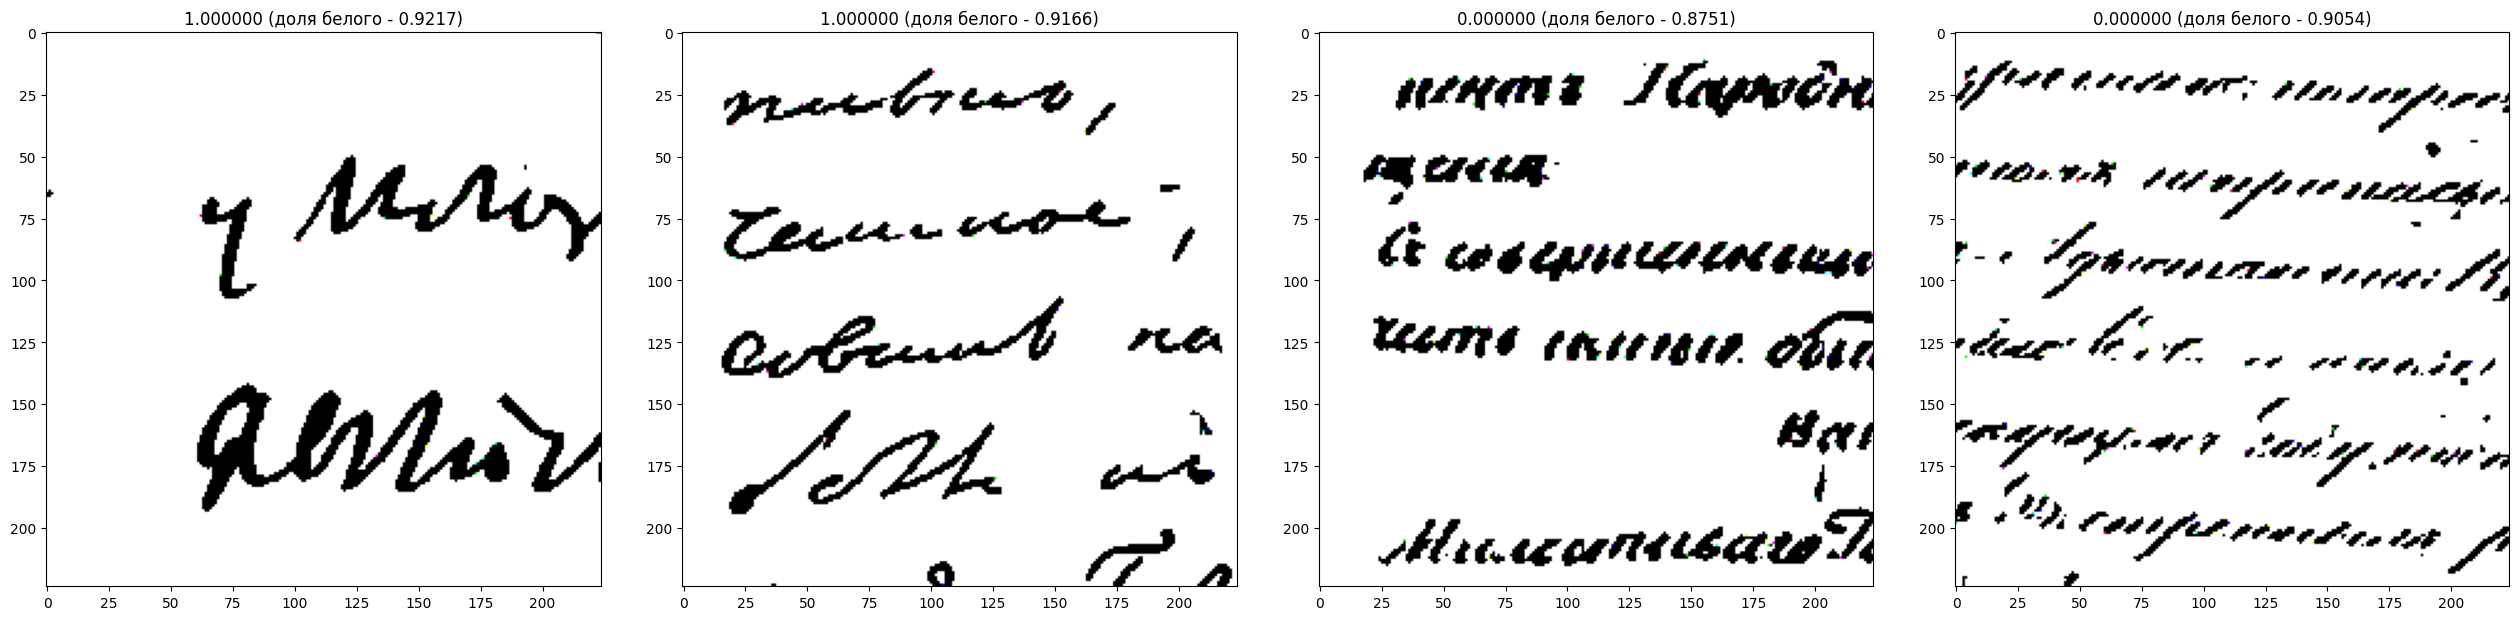

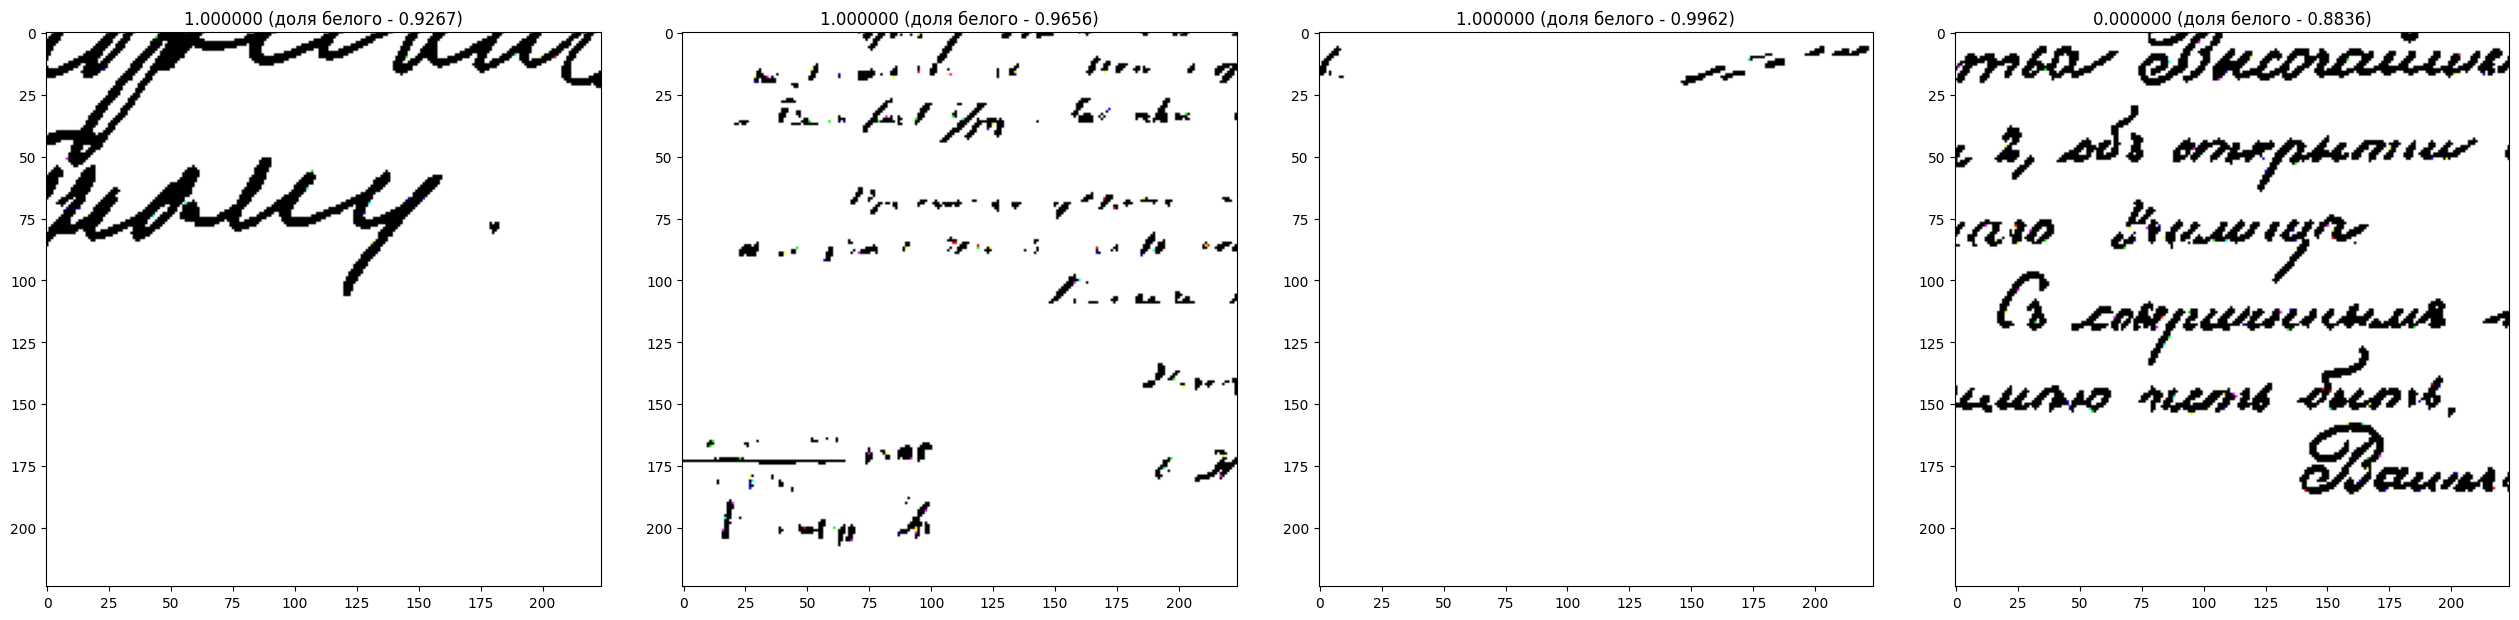

In [10]:
images, labels = next(iter(test_loader))
print(images.shape, labels)
show_images(images, labels, 8)

# freeze_layers

In [11]:
def number_of_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [12]:
model = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)
# list(model.children())
# dir(model)
print(f"num parameters = {number_of_parameters(model)}")
model.fc

num parameters = 11689512


Linear(in_features=512, out_features=1000, bias=True)

In [13]:
def create_model(model, num_non_freeze, num_out_classes):
    # замена последнего слоя сети
    model.fc = nn.Linear(512, num_out_classes)

    num_param = number_of_parameters(model)
    num_freeze = num_param - num_non_freeze

    # заморозка слоев
    cur_freeze = 0
    for i, layer in enumerate(model.children()):
        for param in layer.parameters():
            if param.requires_grad:
                if cur_freeze >= num_freeze:
                    return model

                param.requires_grad = False
                cur_freeze += param.numel()
                # print(num_param - cur_freeze)

In [14]:
num_layers = len(list(model.children()))
print(f"Число слоёв: {num_layers}")
num_classes = 2
print(f"Число классов: {num_classes}")
# num_freeze_layers = num_layers - 3
num_non_freeze = 2361346
# print(f"freeze - {num_freeze_layers}/{num_layers}")
num_param = number_of_parameters(model)
print(f"num_non_freeze - {num_non_freeze}/{num_param}")

seed_everything(42)
model = create_model(model, num_non_freeze, num_classes).to(DEVICE)

print(f"num parameters = {number_of_parameters(model)}")
model.fc

Число слоёв: 10
Число классов: 2
num_non_freeze - 2361346/11689512
num parameters = 2361346


Linear(in_features=512, out_features=2, bias=True)

In [15]:
# for i, layer in enumerate(model.children()):
#     for param in layer.parameters():
#         if param.requires_grad:
#             print(i, layer, param.shape, param, param.requires_grad, sep = "\n")

In [16]:
# model.load_state_dict(torch.load(PATH, map_location=DEVICE))

# train

In [17]:
# file = 'out.txt'
# with open(file, 'w') as f:
#     f.write("12313212313")

In [18]:
# print("# Epoch {:4}/{} train/val:".format(10,12))
# print("# Epoch {:4}/{} train/val:".format(1000,12))

In [19]:
# log = f"# Epoch {{:{len(str(n_epoch))}}}/{n_epoch} "
# log += f"train/val: loss {{:6.5f}}/{{:6.5f}}, accuracy: {{:6.5f}}/{{:6.5f}}"

# print(log.format(100,
#                          1,
#                          1,
#                          1,
#                          1),
#                          )

In [20]:
start_time = time()
seed_everything(42)

loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LR)

model = train(model, train_loader, test_loader, loss_fn, optimizer, EPOCHES, globals=glob_dict)
torch.save(model.state_dict(), PATH)

print(f"# Время работы: {(time() - start_time):6.5f}s")

# Epoch  1/29 train/val: loss 0.30791/0.39391, accuracy: 89.3960%/82.3529%
# Epoch  2/29 train/val: loss 0.22983/0.34323, accuracy: 92.4832%/83.9572%
# Epoch  3/29 train/val: loss 0.17590/0.33388, accuracy: 95.0336%/83.9572%
# Epoch  4/29 train/val: loss 0.15629/0.31365, accuracy: 95.1678%/85.5615%
# Epoch  5/29 train/val: loss 0.14515/0.34912, accuracy: 96.1074%/82.8877%
# Epoch  6/29 train/val: loss 0.11966/0.34957, accuracy: 97.8523%/82.8877%
# Epoch  7/29 train/val: loss 0.09469/0.34290, accuracy: 98.5235%/81.8182%
# Epoch  8/29 train/val: loss 0.09441/0.35056, accuracy: 98.7919%/81.8182%
# Epoch  9/29 train/val: loss 0.06391/0.32993, accuracy: 98.9262%/85.0267%
# Epoch 10/29 train/val: loss 0.06011/0.33441, accuracy: 99.7315%/86.0963%
# Epoch 11/29 train/val: loss 0.05720/0.33215, accuracy: 99.4631%/83.4225%
# Epoch 12/29 train/val: loss 0.05122/0.31478, accuracy: 99.4631%/86.0963%
# Epoch 13/29 train/val: loss 0.04519/0.32988, accuracy: 99.5973%/85.5615%
# Epoch 14/29 train/val: 

In [21]:
# Эпоха 100/100 train/val: loss 0.29161/0.43746, accuracy: 0.88322/0.79144
# Время работы: 250.26071s

In [22]:
# Эпоха 100/100 train/val: loss 0.2623/0.41863, accuracy: 0.88859/0.81283
# Время работы: 249.62457s

# eval

In [23]:
y_pred, y_true, y_prob, _ = get_predictions(model, train_dataset, globals=glob_dict)
accuracy_score(y_pred, y_true)
# 0.897986577181208

0.9986577181208054

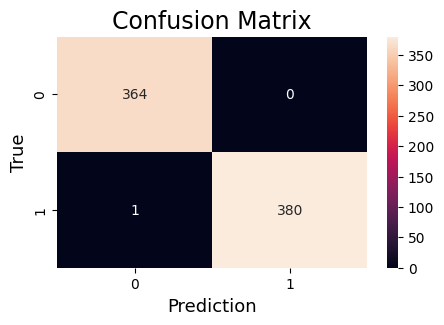

array([[364,   0],
       [  1, 380]])

In [24]:
confusion_matrix(y_true, y_pred)

In [25]:
y_pred, y_true, y_prob, _ = get_predictions(model, test_dataset, globals=glob_dict)
accuracy_score(y_pred, y_true)
# 0.8128342245989305

0.8663101604278075

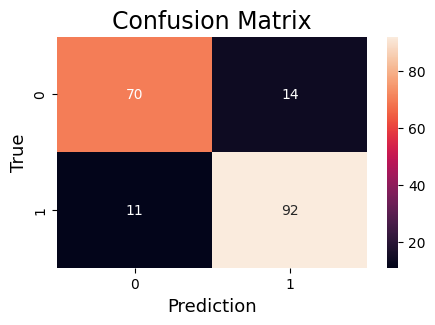

array([[70, 14],
       [11, 92]])

In [26]:
confusion_matrix(y_true, y_pred)

# show

0.9752066115702479


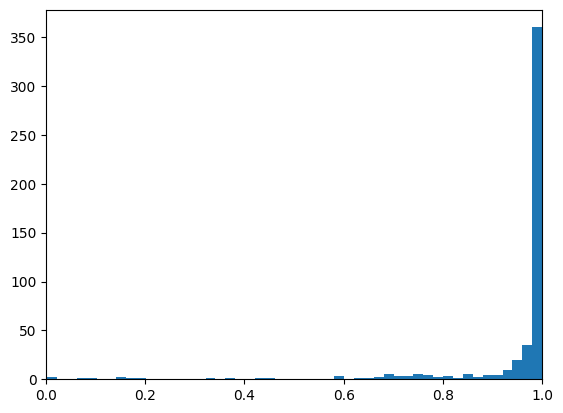

In [27]:
y_pred, y_true, y_prob, _ = get_predictions(model, pos_dataset, globals=glob_dict)
print(accuracy_score(y_pred, y_true))

_ = plt.hist(y_prob.numpy(), bins = 50)
plt.xlim((0,1))
plt.show()
# 0.9504132231404959

0.96875


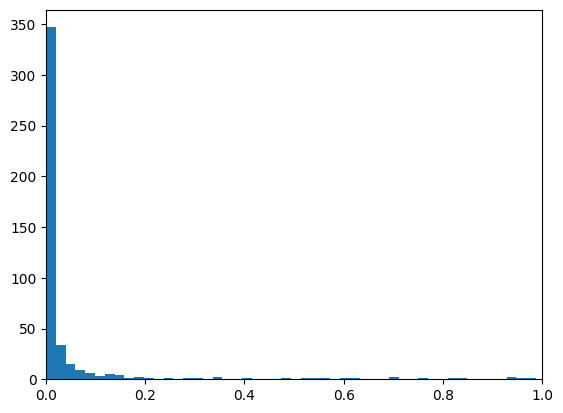

In [28]:
y_pred, y_true, y_prob, _ = get_predictions(model, neg_dataset, globals=glob_dict)
print(accuracy_score(y_pred, y_true))

_ = plt.hist(y_prob.numpy(), bins = 50)
plt.xlim((0,1))
plt.show()
# 0.8058035714285714

In [29]:
# pos_loader = DataLoader(pos_dataset, batch_size=BATCH_SIZE, shuffle=False)
# neg_loader = DataLoader(neg_dataset, batch_size=BATCH_SIZE, shuffle=False)

prob > 0.8
count : 443 out of 484
pic idx : [0, 1, 2, 3, 4, 5, 6, 7]


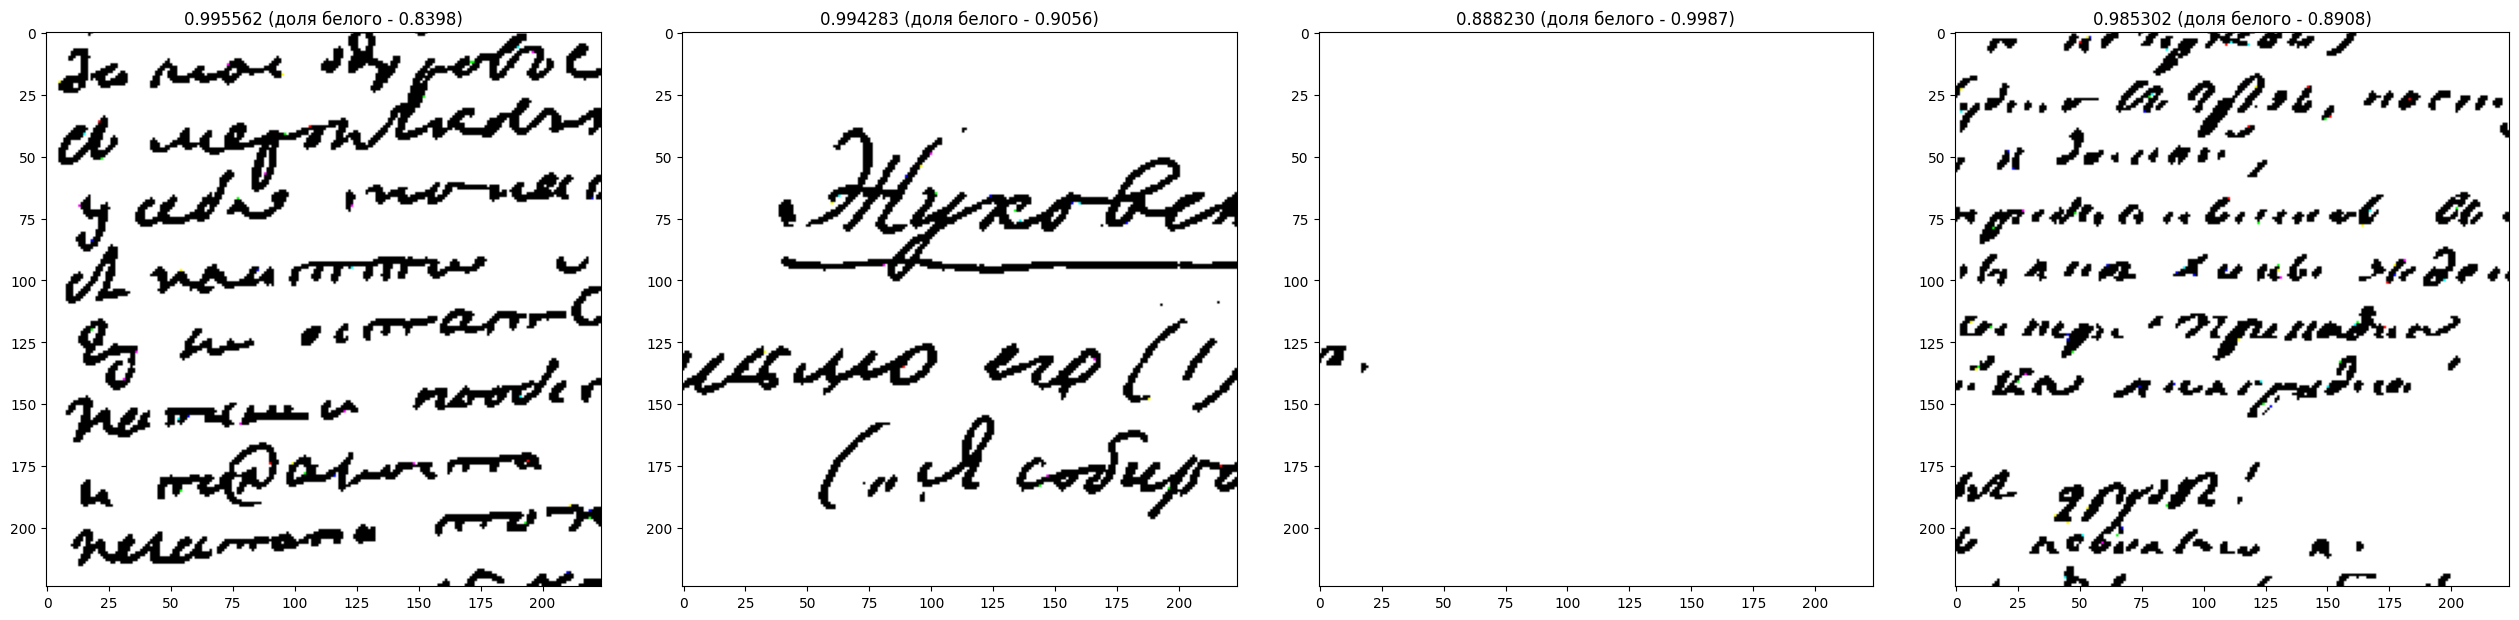

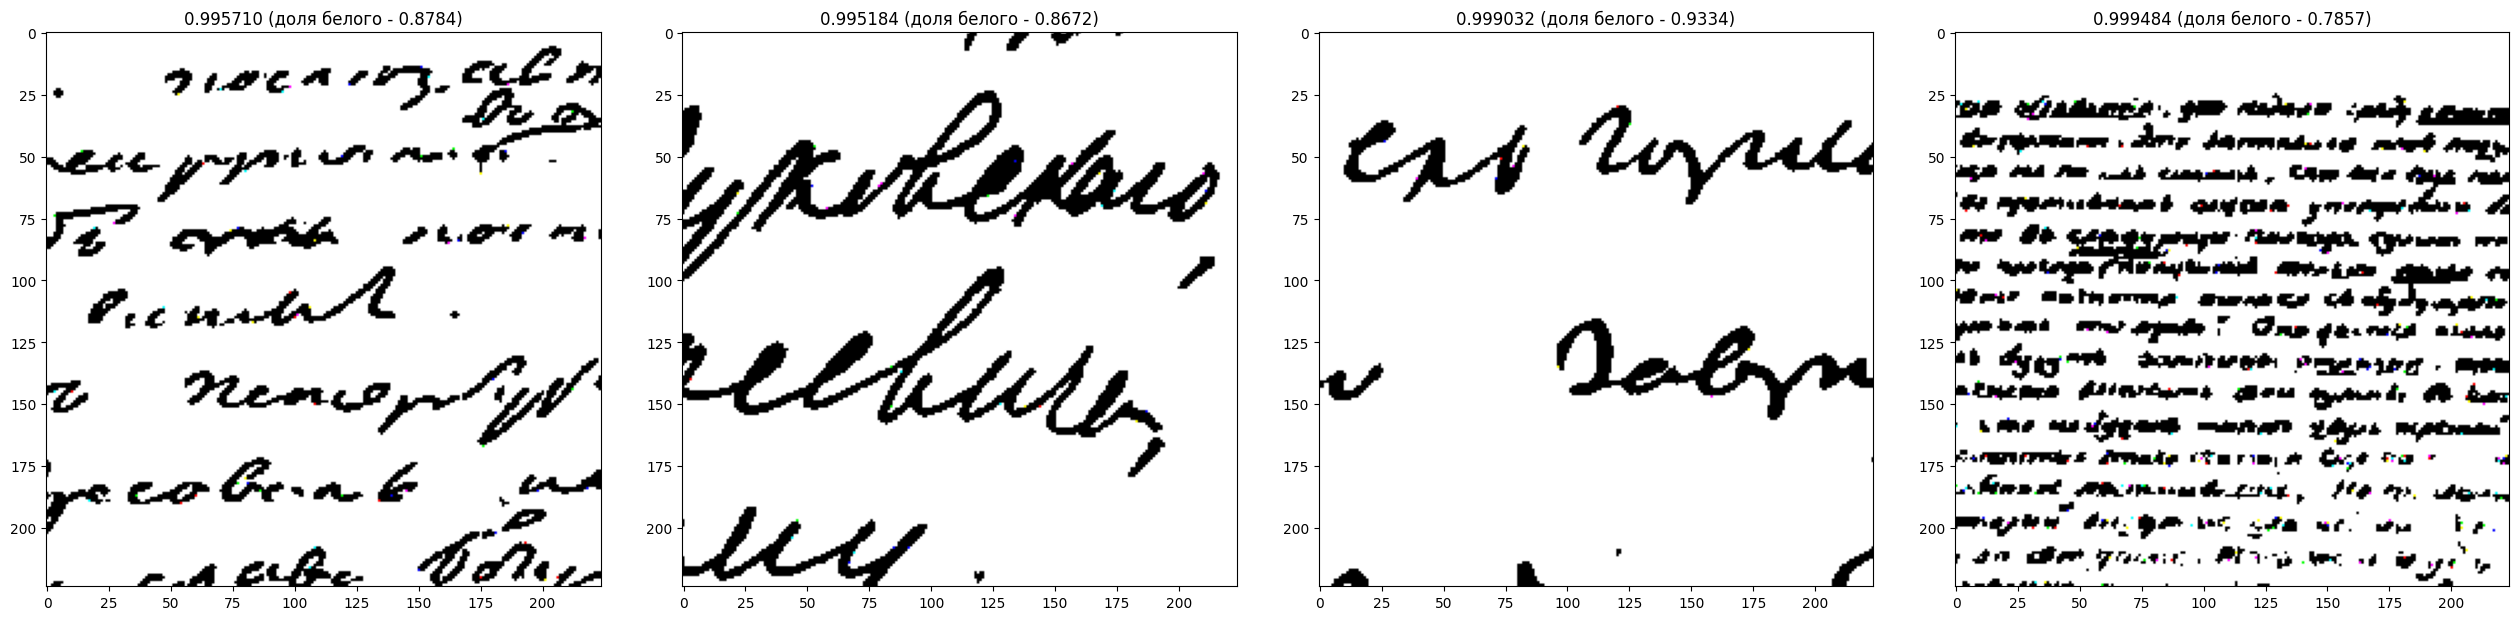

In [30]:
y_pred, _, y_prob, X = show_result(model, pos_dataset, 0.8, greater=True, col = 8,
                                   globals=glob_dict)

prob < 0.6
count : 15 out of 484
pic idx : [67, 84, 86, 92, 102, 231, 235, 260]


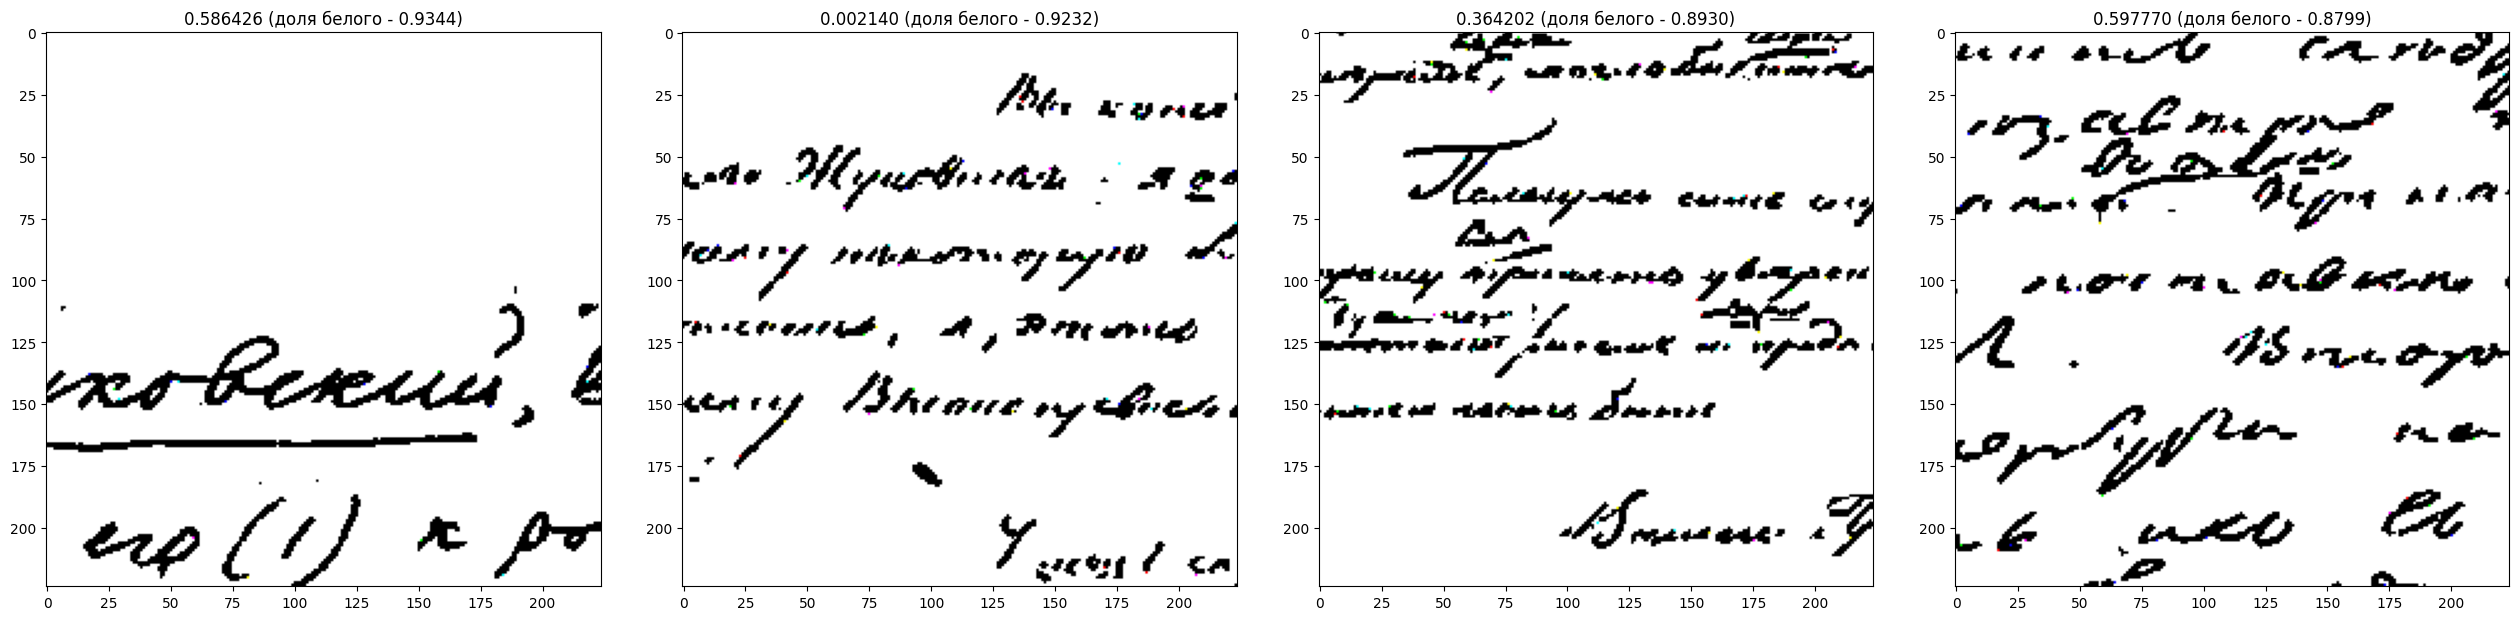

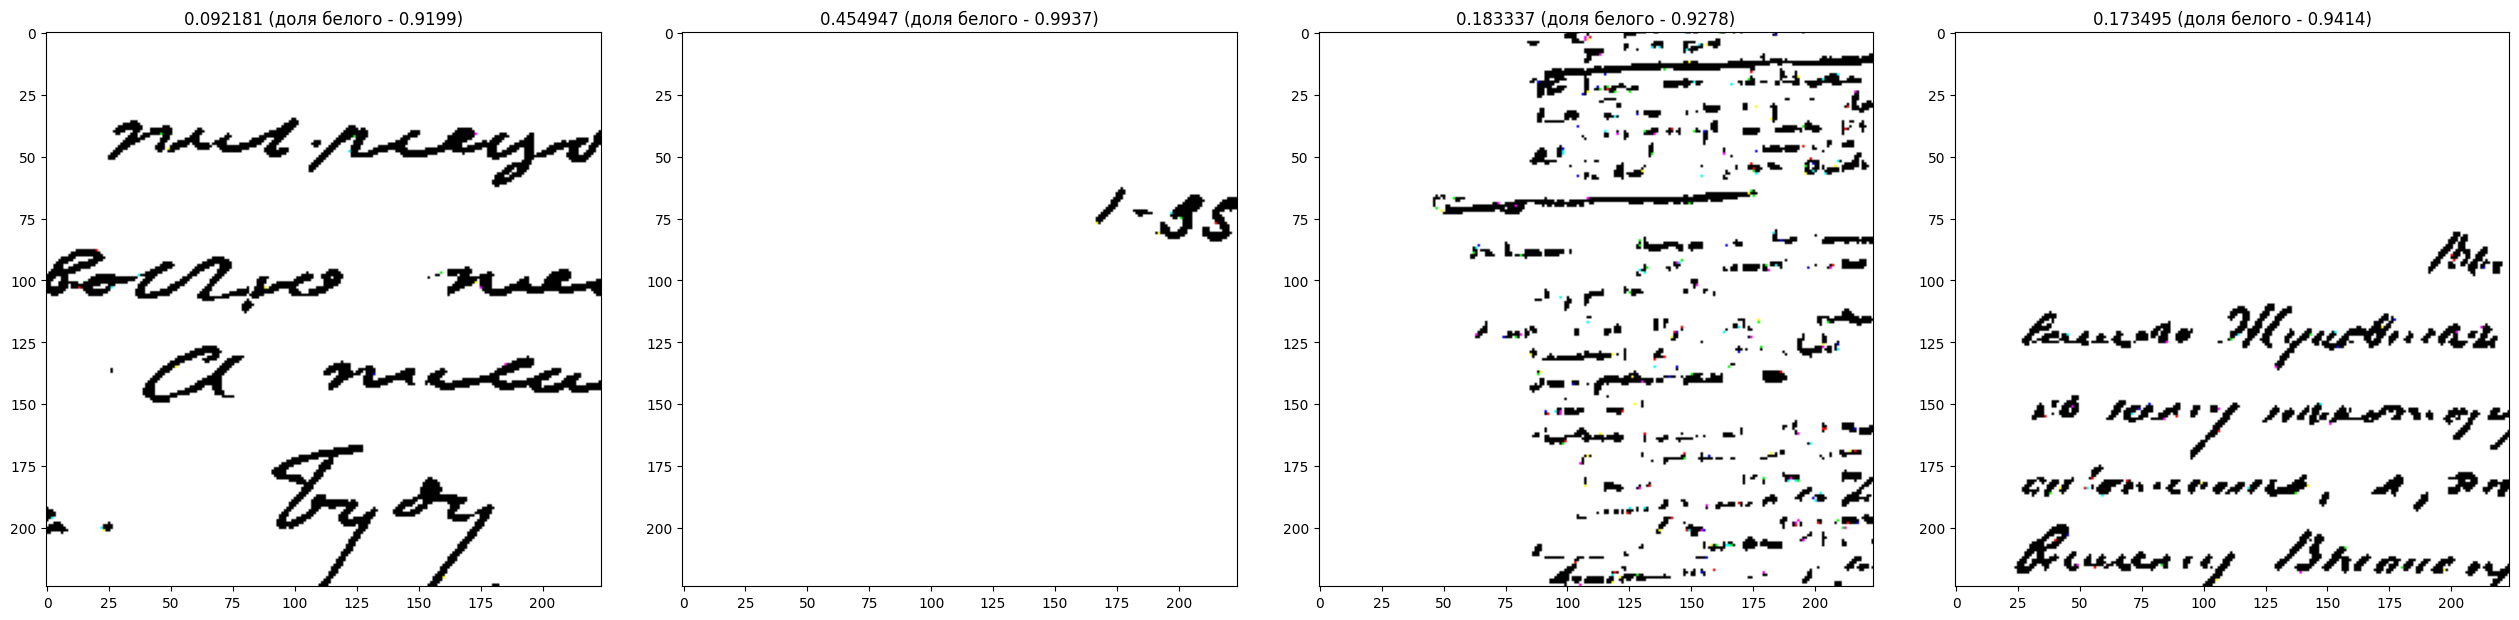

In [31]:
y_pred, _, y_prob, X = show_result(model, pos_dataset, 0.6, greater = False, col = 8,
                                   globals=glob_dict)

In [32]:
y_pred, _, y_prob, X = show_result(model, neg_dataset, 0.3, greater = False, col = 24,
                                   seed = 41, globals=glob_dict)

Output hidden; open in https://colab.research.google.com to view.

prob > 0.3
count : 19 out of 448
pic idx : [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18]


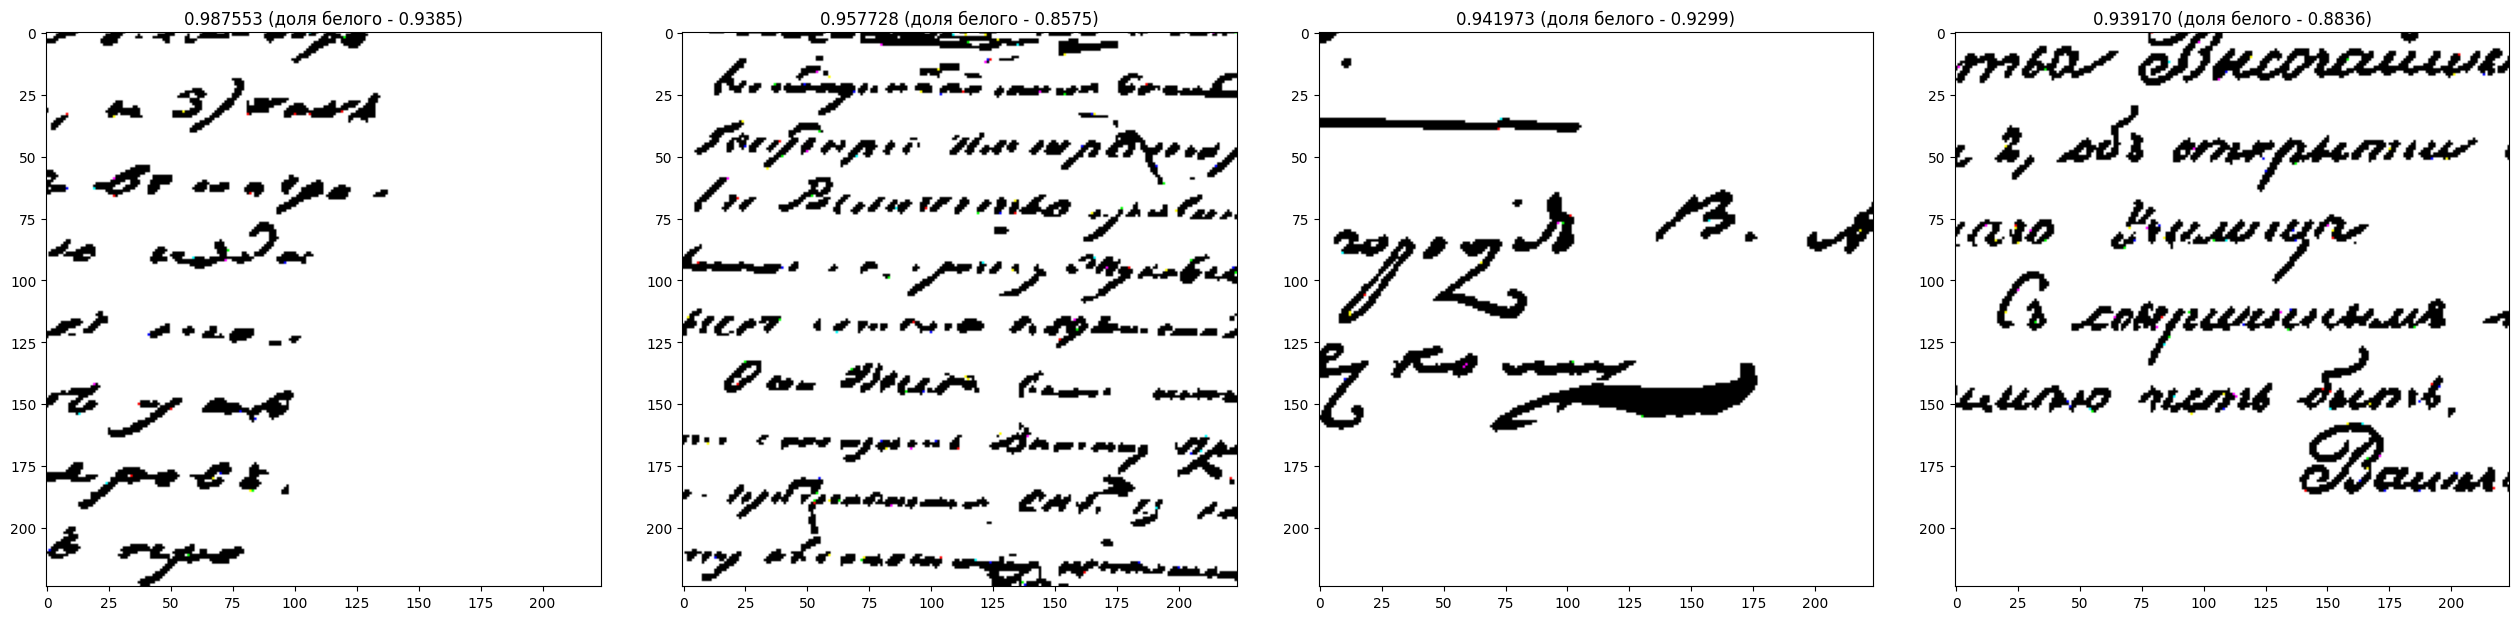

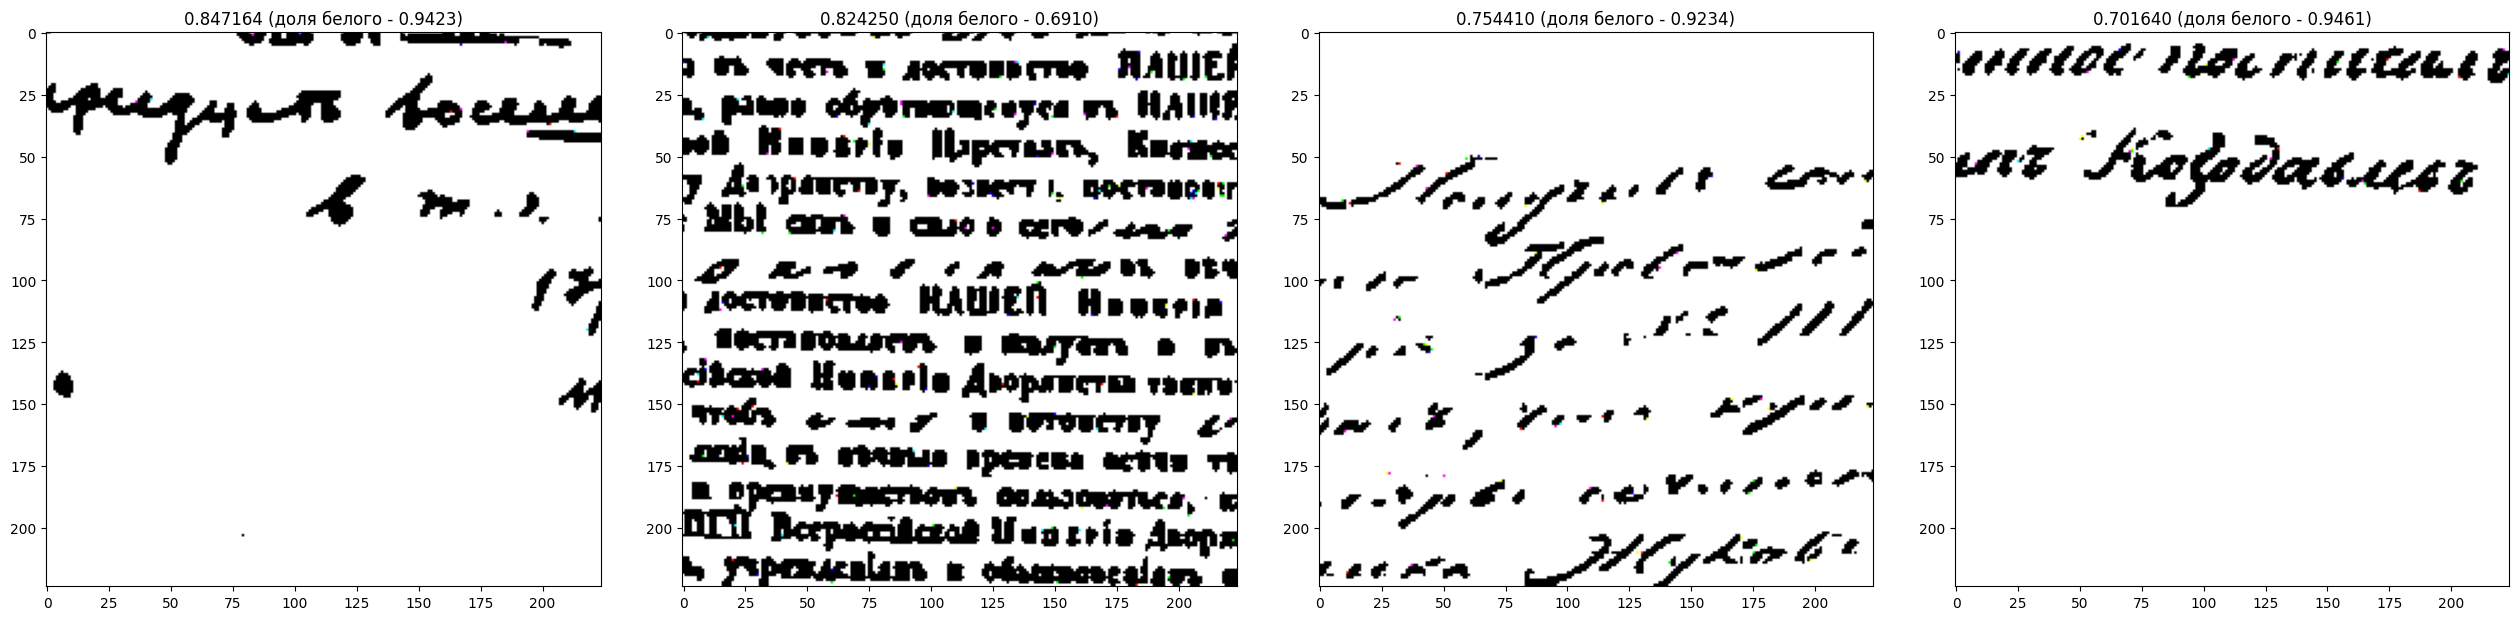

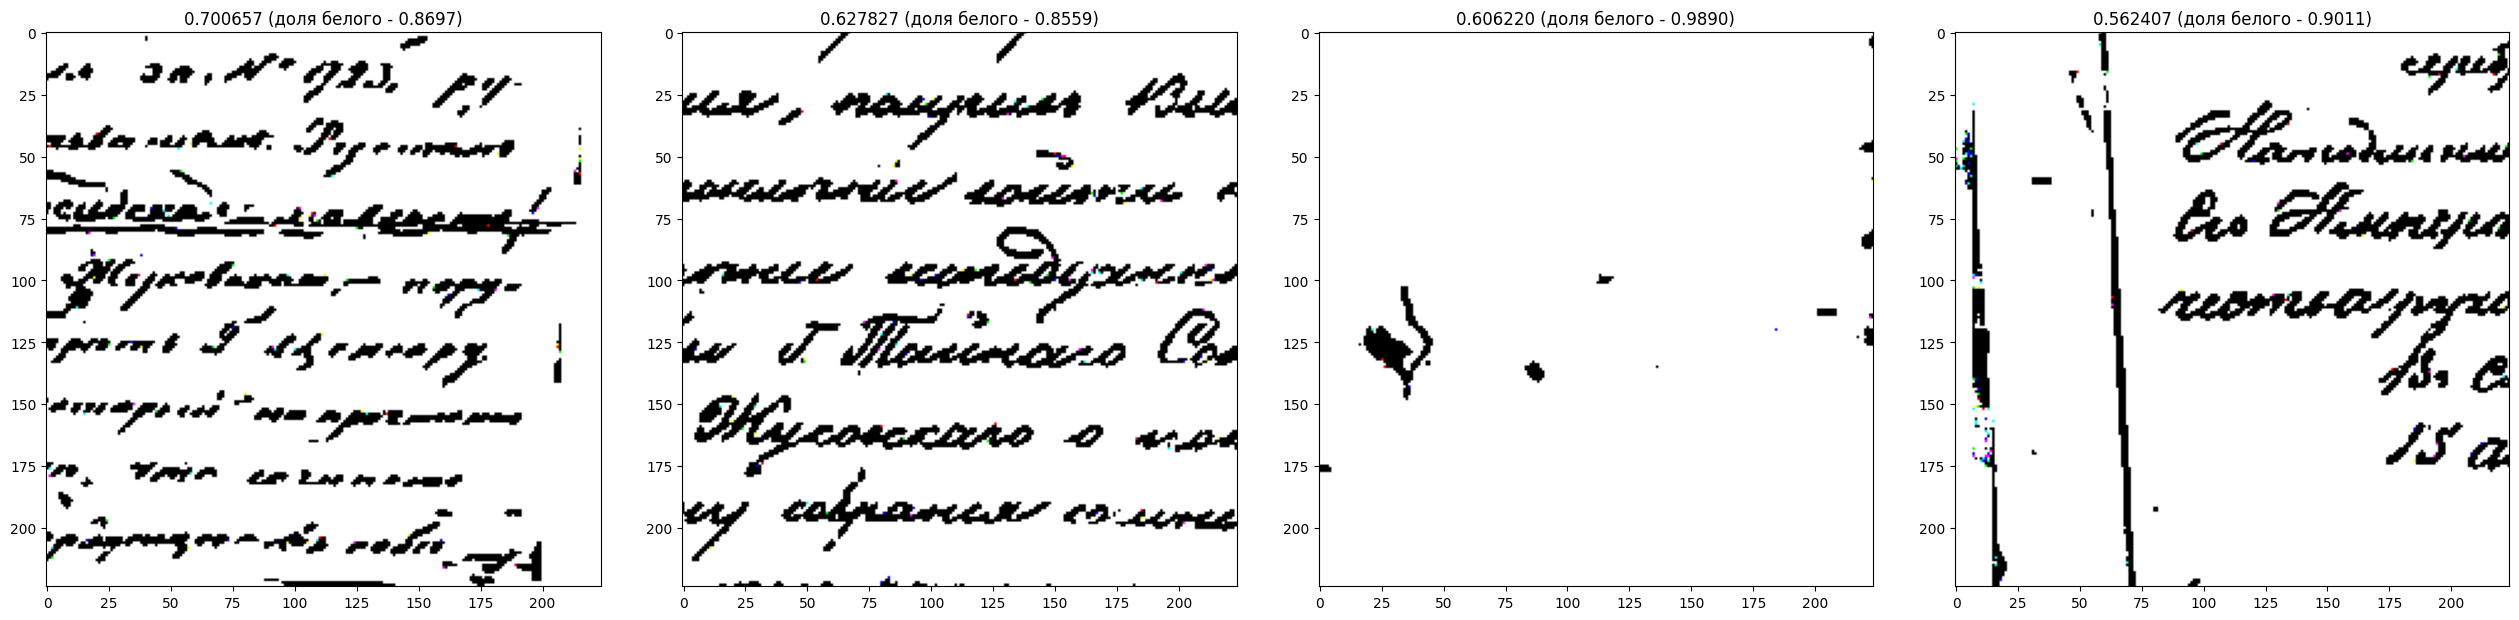

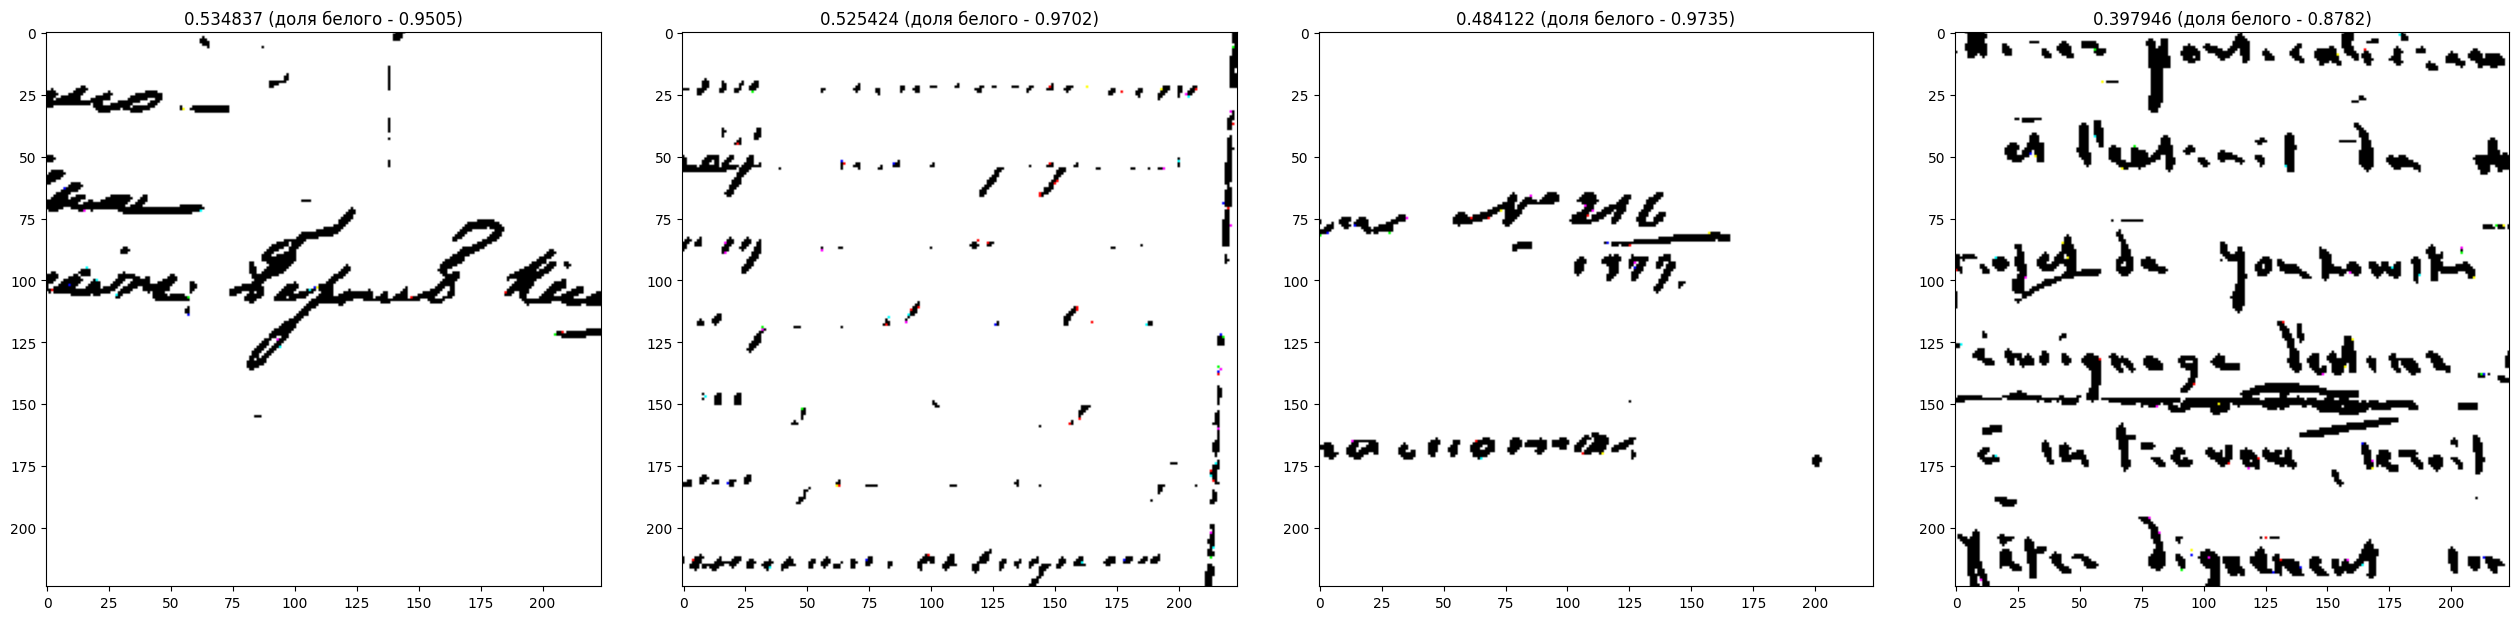

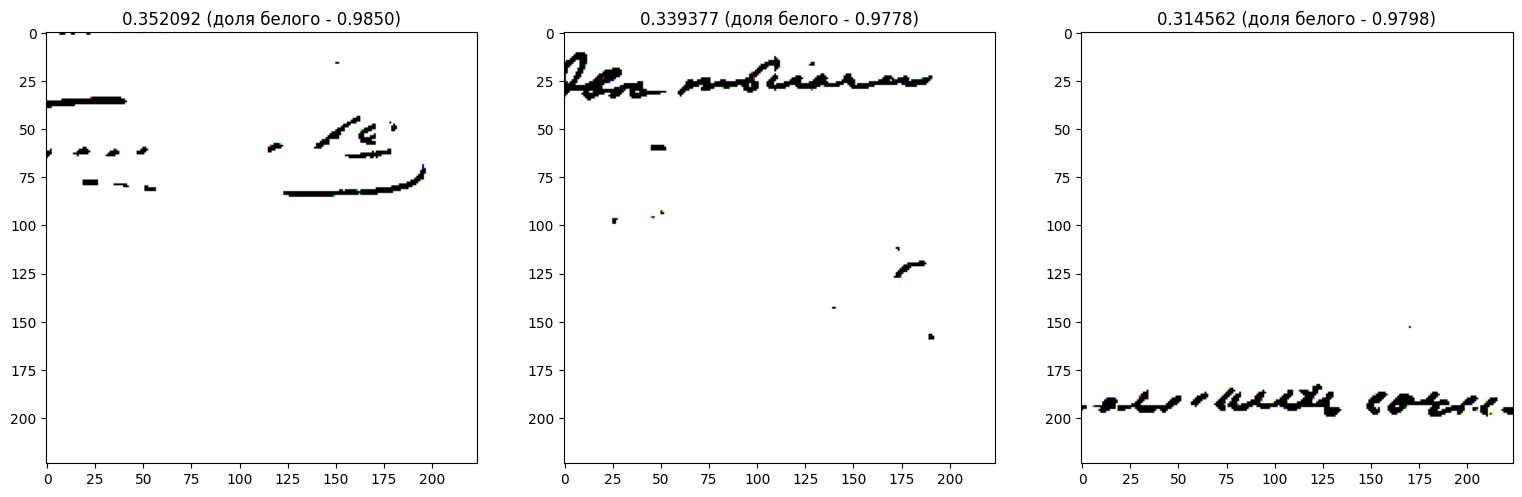

In [40]:
y_pred, _, y_prob, X = show_result(model, neg_dataset, 0.3, greater = True, col = 24,
                                   sort = True, globals=glob_dict)

In [34]:
# img = pos_dataset[0][0]
# img.shape

In [35]:
# s = set()
# for i in range(300):
#     for j in range(300):
#         s |= {tuple(img[:, i, j].tolist())}

# s

In [36]:
# x, num = np.unique(img.max(dim = 0)[0], return_counts = True)
# x, num

In [37]:
# plt.figure(figsize=(20, 20))

# plt.imshow(np.transpose(img, (1, 2, 0)))

# on the entire dataset

In [38]:
y_pred, _, y_prob, X = show_result(model, neg_dataset, 0, greater = True, col = 224,
                                   sort = True, globals=glob_dict)

Output hidden; open in https://colab.research.google.com to view.

In [39]:
y_pred, _, y_prob, X = show_result(model, pos_dataset, 0, greater = True, col = 224,
                                   sort = True, globals=glob_dict)

Output hidden; open in https://colab.research.google.com to view.